# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S14

## Panel A

In [3]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Core/RandomFYN_core_order2_sparse_regularized/task_4/predictions/predicted_phenotypes_supp.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

mut_pos_numbers=[2, 4, 8, 10, 15, 16, 18, 22, 24, 26, 35, 37, 48, 52, 53]

cores = {'P06241' : [i for i in mut_pos_numbers]}
predicted_phenotypes["core"] = pd.Series(dtype="object") 
for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)

In [4]:
from seaborn import kdeplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]
def normalize_errors(values, bounds):
    return [x * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

RT=303*0.001987
predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)

predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)

predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT

reference=predicted_phenotypes.loc[predicted_phenotypes['WT']==True].iloc[0]['aa_seq']

fig = plt.figure(figsize=(0,0))
lines = kdeplot(data=predicted_phenotypes,x='mean',linewidth=0).get_lines()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
plt.close()

predicted_phenotypes['mean']=normalize(list(predicted_phenotypes['mean']),{'actual': {'lower': mode, 'upper': predicted_phenotypes.loc[predicted_phenotypes['aa_seq']==fyn_wt].iloc[0]['mean']}, 'desired': {'lower': -1, 'upper': 0}})
predicted_phenotypes['std'] = normalize_errors(list(predicted_phenotypes['std']),{'actual': {'lower': mode, 'upper':predicted_phenotypes.loc[predicted_phenotypes['aa_seq']==fyn_wt].iloc[0]['mean']}, 'desired': {'lower': -1, 'upper': 0}})

In [5]:
import pandas as pd
from protlearn.features import aaindex1

amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
#aaind, inds = aaindex1(amino_acids, standardize='zscore')
aaind, inds = aaindex1(amino_acids)
AA_props = pd.DataFrame(data=aaind, columns=inds, index=amino_acids).reset_index().rename(columns={'index':'AA'})
props_dict_simple = {'AA':'AA',
              'BIGC670101': 'vol'}

AA_props_simple = AA_props[list(props_dict_simple.keys())]
AA_props_simple = AA_props_simple.rename(mapper=props_dict_simple, axis=1)

/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/protlearn/features/aaindex1.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
import pandas as pd

aa_to_vol = dict(zip(AA_props_simple['AA'], AA_props_simple['vol']))

def calculate_total_volume(sequence):
    return sum(aa_to_vol[aa] for aa in sequence if aa in aa_to_vol)

predicted_phenotypes['total_volume'] = predicted_phenotypes['core'].apply(calculate_total_volume)

wt_volume = predicted_phenotypes.loc[predicted_phenotypes['WT']==True, 'total_volume'].values[0]

predicted_phenotypes['volume_change'] = (
    predicted_phenotypes['total_volume'] - wt_volume
)

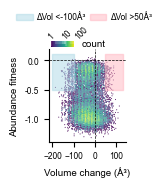

In [7]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, AutoLocator

proteins = ['P06241']
subcategories = {'Volume':'Volume',
                'Number of sidechain heavy atoms':'#SC atoms'}
protein_names = {'P06241': 'FYN-SH3'}

for protein in proteins:
    bestindices = {'Volume': 'BIGC670101'}
    #bestindices = {}
    for prop in ['Volume']:

        x = predicted_phenotypes.loc[predicted_phenotypes['fitness'].notna()][['volume_change']].to_numpy()
        y = predicted_phenotypes.loc[predicted_phenotypes['fitness'].notna()][['fitness']].to_numpy()
        model = LinearRegression()
        model.fit(x,y)
        y_pred = model.predict(x)
        
        fig, ax = plt.subplots(figsize=(1,1.2))
        hbin=ax.hexbin(y= predicted_phenotypes.loc[predicted_phenotypes['fitness'].notna()][['fitness']],x=predicted_phenotypes.loc[predicted_phenotypes['fitness'].notna()][['volume_change']],bins='log',gridsize=75,rasterized=True,linewidths=0)
        #ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)

        
        plt.axvline(0, ls='--', color='black', lw=0.5)
        plt.axhline(0, ls='--', color='black', lw=0.5)

        # Add the shaded areas
        # Shade area where y > 7 and x < -0.5 (light blue)
        y_max=ax.get_ylim()[1]
        x_vals = np.linspace(ax.get_xlim()[0], -100, 100)
        ax.fill_between(x_vals, -0.5, y_max, color='lightblue', alpha=0.5)
        
        # Shade area where y < 0 and x < -0.5 (light pink)
        x_vals = np.linspace(50, ax.get_xlim()[1], 100)
        ax.fill_between(x_vals, -0.5, y_max, color='lightpink', alpha=0.5)
        
        #plt.title(protein_names[protein]+' buried\nresidue randomization'+'\nR$^2$ = '+str(round(r2_score(y,y_pred),3)),fontsize=7, color='k', loc='center', pad=22)
        
        plt.ylabel('Abundance fitness', fontsize=7)
        plt.xticks(fontsize=6)
        if prop == 'Volume':
            plt.xlabel('Volume change (Å³)', fontsize=7)
        else:
            plt.xlabel('Change in number of\nsidechain heavy atoms',fontsize=7)
        plt.yticks(fontsize=6)
        #ax.set_xticks(np.arange(-6,12,2))
        ax.set_yticks(np.arange(-1,0.5,0.5),np.arange(-1,0.5,0.5),fontsize=6)
        #ax.set_ylim(-1.3,0.2)
        #ax.set_xlim(-1.85,0.2)
        # Access the current axis
        ax = plt.gca()
        
        # Use AutoLocator to get the default tick positions
        auto_locator = AutoLocator()
        default_ticks = auto_locator.tick_values(*ax.get_xlim())
        
        # Calculate a refined tick interval to add a middle tick if needed
        if len(default_ticks) > 1:
            tick_interval = default_ticks[1] - default_ticks[0]
            refined_locator = MultipleLocator(tick_interval*2)  # Half the default interval
            ax.xaxis.set_major_locator(refined_locator)
        ax.spines[['top','right']].set_visible(False)
        ax.set_rasterization_zorder(0)
        fmt = '%1.f'
        cax=fig.add_axes([0.15,0.9,0.3,0.05])
        cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
        cb.outline.set_visible(False)
        cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
        cb.ax.xaxis.set_tick_params(pad=0)
        cb.set_ticks([1,10,100])
        cb.set_ticklabels([1,10,100], fontsize=6, rotation=45)
        ax1 = cb.ax
        ax1.text(100,0.1,'count',rotation=0, fontsize=7)

        # Add custom legend handles for the shaded regions
        light_blue_patch = mpatches.Patch(color='lightblue', label='ΔVol <-100Å³', alpha=0.5)
        light_pink_patch = mpatches.Patch(color='lightpink', label='ΔVol >50Å³', alpha=0.5)
        
        # Create the legend
        plt.legend(handles=[light_blue_patch, light_pink_patch], fontsize=6, frameon=False, bbox_to_anchor=[3.6,7],ncol=2,columnspacing=0.5,handletextpad=0.4, labelspacing=0)

## Panel B

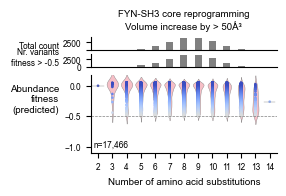

In [8]:
import seaborn as sns
import networkx as nx
from itertools import count
from seaborn import kdeplot
from itertools import groupby
import matplotlib
import numpy as np

vol_increase=50

filtered_phenotypes = predicted_phenotypes[['aa_seq', 'Nham_aa','core', 'volume_change','mean','mean_dG','fitness']].loc[predicted_phenotypes['volume_change']>vol_increase].loc[predicted_phenotypes['mean']>-0.5].sort_values(['mean','volume_change'],ascending=[True,True]).copy()

filtered_phenotypes = filtered_phenotypes.sort_values('mean', ascending=False)

lowest_nham=int(filtered_phenotypes.sort_values('Nham_aa', ascending=True).iloc[0]['Nham_aa'])
highest_nham=int(filtered_phenotypes.sort_values('Nham_aa', ascending=False).iloc[0]['Nham_aa'])

total_core_viabilities = pd.DataFrame(columns=['protein', 'variants_above_01', 'variants_above_025', 'variants_above_05', 'variants_below_05'])
    

fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,0,12],'hspace': 0.15},figsize=(2.4,1.5))
plt.close()
fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,0,12],'hspace': 0.15},figsize=(2.4,1.5),sharex=ax1)


fig=sns.violinplot(x="Nham_aa", y="mean", data=filtered_phenotypes, inner=None, ax=ax2, color='lightpink', linewidth=0.3)
plt.axhline(y=-0.5, linestyle='--', color='gray', linewidth=0.5)

total_viable=0
nham_viability=pd.DataFrame(columns=['Number_of_variants','Fraction_50pc_folded'])
nham_viability["protein"] = pd.Series(dtype="object") 
nham_viability["nham"] = pd.Series(dtype=int) 
for nham in range(lowest_nham,highest_nham+1,1):
    if len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham]) > 0:
        nham_viability.at[nham,'protein']='FYN'
        nham_viability.at[nham,'nham']=nham
        nham_viability.at[nham,'Number_of_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])
        nham_viability.at[nham,'Fraction_50pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_50pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)
        nham_viability.at[nham,'Fraction_75pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.25].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_75pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.25].index)
        nham_viability.at[nham,'Fraction_90pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.1].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_90pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.1].index)
        total_viable=total_viable+len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)
for index, row in nham_viability.iterrows():
    nham_viability.at[index,'Fraction_of_total_50pc_viable_variants']= round(100*row['Number_of_50pc_folded_variants']/total_viable,1)

total_core_viabilities.at['core','variants_above_01']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.1].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_above_025']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.25].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_below_05']=5**7-len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_above_05']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.index)*5**7
    
   

sns.scatterplot(x=filtered_phenotypes['Nham_aa']-lowest_nham,y=filtered_phenotypes['mean'], hue=filtered_phenotypes['mean'],palette='coolwarm_r', hue_norm=(-1, 0),legend=False, s=3, edgecolor=None,ax=ax2,rasterized=True)
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.set_xlabel('Number of amino acid substitutions', fontsize=7)
ax2.set_ylabel("Abundance\nfitness\n(predicted)", fontsize=7,rotation='horizontal', ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=6)

nham_viability['Fraction_50pc_folded'] = pd.to_numeric(nham_viability['Fraction_50pc_folded'], errors='coerce')

ax1.spines[['top','right','left','bottom']].set_visible(False)
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False,top=False, right=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
ax2.annotate('n='+f"{len(filtered_phenotypes):,}", (-0.3,-1), fontsize=6)
plt.subplots_adjust(hspace=0.05)

nham_viability['Number_of_variants'].plot.bar(ax=ax0,fontsize=6,color='gray')
ax0.spines[['top','right']].set_visible(False)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax0.set_ylabel('Total count',fontsize=6, rotation='horizontal', ha='right')
ticks = ax0.get_yticks()
new_ticks = ticks[:-1]
ax0.set_yticks(new_ticks)
ticks = ax0.get_yticks()
labels = [label.get_text() for label in ax0.get_yticklabels()]
labels[0]= ""
ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)

nham_viability['Number_of_50pc_folded_variants'].plot.bar(ax=axviable,fontsize=6,color='gray')
axviable.spines[['top','right']].set_visible(False)
axviable.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axviable.set_ylabel('Nr. variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')

labeloffset= -0.17
ax0.get_yaxis().set_label_coords(labeloffset,0)
axviable.get_yaxis().set_label_coords(labeloffset,0)
ax1.get_yaxis().set_label_coords(labeloffset,-1)
ax2.get_yaxis().set_label_coords(labeloffset,0.5)
plt.ylim(-1.1,0.18)
ax0.set_title('FYN-SH3 core reprogramming\nVolume increase by > '+str(vol_increase)+'Å³',fontsize=7)
plt.show()

/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '-' is not in color_dict. Using black.
  warnings.warn(str(Error))


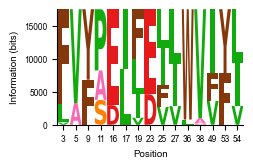

In [9]:
import logomaker as lm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning, module="logomaker")

reprogram_MSA = pd.DataFrame(columns=np.arange(1,len(fyn_wt)+1,1))
for index, row in filtered_phenotypes.iterrows():
    reprogram_MSA.loc[index]=list(row.aa_seq)

aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
fig, ax = plt.subplots(figsize=(2.4, 1.5))

logo_df = pd.DataFrame(columns=aas)
logo_df = logo_df.astype(float)

for pos in range(1, len(reprogram_MSA.columns) + 1):
    df = reprogram_MSA[pos].value_counts().rename_axis('aa').reset_index(name='counts')
    for index, row2 in df.iterrows():
        logo_df.at[pos, row2.aa] = int(row2.counts)

logo_df = logo_df.fillna(0)

logo_df_subset = logo_df.loc[[i+1 for i in mut_pos_numbers]]

logo_df_subset_reset = logo_df_subset.reset_index()

prob_mat = lm.transform_matrix(logo_df_subset_reset.drop(columns='index'), from_type='counts', to_type='counts')
logo = lm.Logo(prob_mat, font_name='DejaVu Sans', ax=ax, color_scheme='dmslogo_funcgroup')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(range(len(mut_pos_numbers)))
ax.set_xticklabels([i+1 for i in mut_pos_numbers], fontsize=6)
ax.tick_params(axis='y', labelsize=6)

plt.xlabel('Position', fontsize=7)
plt.ylabel('Information (bits)', fontsize=7)
plt.show()


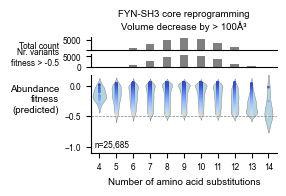

In [10]:
import seaborn as sns
import networkx as nx
from itertools import count
from seaborn import kdeplot
from itertools import groupby
import matplotlib
import numpy as np

vol_increase=-100

filtered_phenotypes = predicted_phenotypes[['aa_seq', 'Nham_aa','core', 'volume_change','mean','mean_dG','fitness']].loc[predicted_phenotypes['volume_change']<vol_increase].loc[predicted_phenotypes['mean']>-0.5].sort_values(['mean','volume_change'],ascending=[True,True]).copy()

filtered_phenotypes = filtered_phenotypes.sort_values('mean', ascending=False)

lowest_nham=int(filtered_phenotypes.sort_values('Nham_aa', ascending=True).iloc[0]['Nham_aa'])
highest_nham=int(filtered_phenotypes.sort_values('Nham_aa', ascending=False).iloc[0]['Nham_aa'])

total_core_viabilities = pd.DataFrame(columns=['protein', 'variants_above_01', 'variants_above_025', 'variants_above_05', 'variants_below_05'])
    

fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,0,12],'hspace': 0.15},figsize=(2.4,1.5))
plt.close()
fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,0,12],'hspace': 0.15},figsize=(2.4,1.5),sharex=ax1)


fig=sns.violinplot(x="Nham_aa", y="mean", data=filtered_phenotypes, inner=None, ax=ax2, color='lightblue', linewidth=0.3)
plt.axhline(y=-0.5, linestyle='--', color='gray', linewidth=0.5)

total_viable=0
nham_viability=pd.DataFrame(columns=['Number_of_variants','Fraction_50pc_folded'])
nham_viability["protein"] = pd.Series(dtype="object") 
nham_viability["nham"] = pd.Series(dtype=int) 
for nham in range(lowest_nham,highest_nham+1,1):
    if len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham]) > 0:
        nham_viability.at[nham,'protein']='FYN'
        nham_viability.at[nham,'nham']=nham
        nham_viability.at[nham,'Number_of_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])
        nham_viability.at[nham,'Fraction_50pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_50pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)
        nham_viability.at[nham,'Fraction_75pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.25].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_75pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.25].index)
        nham_viability.at[nham,'Fraction_90pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.1].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_90pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.1].index)
        total_viable=total_viable+len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)
for index, row in nham_viability.iterrows():
    nham_viability.at[index,'Fraction_of_total_50pc_viable_variants']= round(100*row['Number_of_50pc_folded_variants']/total_viable,1)

total_core_viabilities.at['core','variants_above_01']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.1].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_above_025']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.25].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_below_05']=5**7-len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_above_05']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.index)*5**7
    
   

sns.scatterplot(x=filtered_phenotypes['Nham_aa']-lowest_nham,y=filtered_phenotypes['mean'], hue=filtered_phenotypes['mean'],palette='coolwarm_r', hue_norm=(-1, 0),legend=False, s=3, edgecolor=None,ax=ax2,rasterized=True)
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.set_xlabel('Number of amino acid substitutions', fontsize=7)
ax2.set_ylabel("Abundance\nfitness\n(predicted)", fontsize=7,rotation='horizontal', ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=6)

nham_viability['Fraction_50pc_folded'] = pd.to_numeric(nham_viability['Fraction_50pc_folded'], errors='coerce')

ax1.spines[['top','right','left','bottom']].set_visible(False)
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False,top=False, right=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
ax2.annotate('n='+f"{len(filtered_phenotypes):,}", (-0.3,-1), fontsize=6)
plt.subplots_adjust(hspace=0.05)

nham_viability['Number_of_variants'].plot.bar(ax=ax0,fontsize=6,color='gray')
ax0.spines[['top','right']].set_visible(False)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax0.set_ylabel('Total count',fontsize=6, rotation='horizontal', ha='right')
ticks = ax0.get_yticks()
new_ticks = ticks[:-1]
ax0.set_yticks(new_ticks)
ticks = ax0.get_yticks()
labels = [label.get_text() for label in ax0.get_yticklabels()]
labels[0]= ""
ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)

nham_viability['Number_of_50pc_folded_variants'].plot.bar(ax=axviable,fontsize=6,color='gray')
axviable.spines[['top','right']].set_visible(False)
axviable.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axviable.set_ylabel('Nr. variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')

labeloffset= -0.17
ax0.get_yaxis().set_label_coords(labeloffset,0)
axviable.get_yaxis().set_label_coords(labeloffset,0)
ax1.get_yaxis().set_label_coords(labeloffset,-1)
ax2.get_yaxis().set_label_coords(labeloffset,0.5)
plt.ylim(-1.1,0.18)
ax0.set_title('FYN-SH3 core reprogramming\nVolume decrease by > '+str(abs(vol_increase))+'Å³',fontsize=7)
plt.show()

/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '-' is not in color_dict. Using black.
  warnings.warn(str(Error))


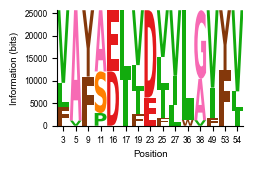

In [11]:
import logomaker as lm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning, module="logomaker")

reprogram_MSA = pd.DataFrame(columns=np.arange(1,len(fyn_wt)+1,1))
for index, row in filtered_phenotypes.iterrows():
    reprogram_MSA.loc[index]=list(row.aa_seq)

aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
fig, ax = plt.subplots(figsize=(2.4, 1.5))

logo_df = pd.DataFrame(columns=aas)
logo_df = logo_df.astype(float)

for pos in range(1, len(reprogram_MSA.columns) + 1):
    df = reprogram_MSA[pos].value_counts().rename_axis('aa').reset_index(name='counts')
    for index, row2 in df.iterrows():
        logo_df.at[pos, row2.aa] = int(row2.counts)

logo_df = logo_df.fillna(0)

logo_df_subset = logo_df.loc[[i+1 for i in mut_pos_numbers]]

logo_df_subset_reset = logo_df_subset.reset_index()

prob_mat = lm.transform_matrix(logo_df_subset_reset.drop(columns='index'), from_type='counts', to_type='counts')
logo = lm.Logo(prob_mat, font_name='DejaVu Sans', ax=ax, color_scheme='dmslogo_funcgroup')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(range(len(mut_pos_numbers)))
ax.set_xticklabels([i+1 for i in mut_pos_numbers], fontsize=6)
ax.tick_params(axis='y', labelsize=6)

plt.xlabel('Position', fontsize=7)
plt.ylabel('Information (bits)', fontsize=7)
plt.show()


## Panel C

In [12]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order2_sparse_regularized/task_4/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

mut_pos_numbers = [0, 5, 6, 7, 9, 11, 12, 13, 14, 19, 20, 27, 30, 31, 32, 33, 41, 42, 51, 55, 56]

cores = {'P06241' : mut_pos_numbers}
predicted_phenotypes["core"] = pd.Series(dtype="object") 
for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)


RT=303*0.001987
predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)

predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)

predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT

for index, row in predicted_phenotypes.loc[predicted_phenotypes['WT']!=True].iterrows():
    predicted_phenotypes.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_phenotypes.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

In [13]:
# Normalize data in the -1 to 0 range
from seaborn import kdeplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]
def normalize_errors(values, bounds):
    return [x * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

reference=predicted_phenotypes.loc[predicted_phenotypes['WT']==True].iloc[0]['aa_seq']

fig = plt.figure(figsize=(0,0))
lines = kdeplot(data=predicted_phenotypes,x='mean',linewidth=0).get_lines()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
plt.close()

predicted_phenotypes['mean']=normalize(list(predicted_phenotypes['mean']),{'actual': {'lower': mode, 'upper': predicted_phenotypes.loc[predicted_phenotypes['aa_seq']==fyn_wt].iloc[0]['mean']}, 'desired': {'lower': -1, 'upper': 0}})
predicted_phenotypes['std'] = normalize_errors(list(predicted_phenotypes['std']),{'actual': {'lower': mode, 'upper':predicted_phenotypes.loc[predicted_phenotypes['aa_seq']==fyn_wt].iloc[0]['mean']}, 'desired': {'lower': -1, 'upper': 0}})


In [14]:
import matplotlib.pyplot as plt
from seaborn import kdeplot
import numpy as np

# Normalize data in the -1 to 0 range

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

predicted_phenotypes = predicted_phenotypes.copy()

reference=predicted_phenotypes.loc[predicted_phenotypes['WT']==True].iloc[0]['aa_seq']

fig = plt.figure(figsize=(0,0))
lines = kdeplot(data=predicted_phenotypes.loc[predicted_phenotypes['fitness']<-1.2],x='fitness',linewidth=0).get_lines()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
plt.close()

predicted_phenotypes['fitness']=normalize(list(predicted_phenotypes['fitness']),{'actual': {'lower': mode, 'upper': predicted_phenotypes.loc[predicted_phenotypes['aa_seq']==reference]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})

predicted_phenotypes['predicted_fitness']=normalize(list(predicted_phenotypes['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})


In [15]:
import pandas as pd
from protlearn.features import aaindex1

amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
aaind, inds = aaindex1(amino_acids)
AA_props = pd.DataFrame(data=aaind, columns=inds, index=amino_acids).reset_index().rename(columns={'index':'AA'})

props_dict_simple = {'AA':'AA',
              'KLEP840101': 'charge'}

AA_props_simple = AA_props[list(props_dict_simple.keys())]
AA_props_simple = AA_props_simple.rename(mapper=props_dict_simple, axis=1)

aa_to_charge = dict(zip(AA_props_simple['AA'], AA_props_simple['charge']))

def calculate_charge(sequence):
    return sum(aa_to_charge[aa] for aa in sequence if aa in aa_to_charge)

predicted_phenotypes['total_charge'] = predicted_phenotypes['core'].apply(calculate_charge)

wt_charge = predicted_phenotypes.loc[predicted_phenotypes['WT']==True, 'total_charge'].values[0]

predicted_phenotypes['charge_change'] = (
    predicted_phenotypes['total_charge'] - wt_charge
)

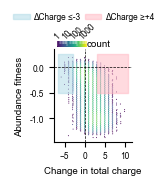

In [16]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, AutoLocator

proteins = ['P06241']
subcategories = {'Volume':'Volume',
                'Number of sidechain heavy atoms':'#SC atoms'}
protein_names = {'P06241': 'FYN-SH3'}

for protein in proteins:
    bestindices = {'Charge': 'KLEP840101'}
    #bestindices = {}
    for prop in ['Charge']:

        x = predicted_phenotypes.loc[predicted_phenotypes['fitness'].notna()][['charge_change']].to_numpy()
        y = predicted_phenotypes.loc[predicted_phenotypes['fitness'].notna()][['fitness']].to_numpy()
        model = LinearRegression()
        model.fit(x,y)
        y_pred = model.predict(x)
        
        fig, ax = plt.subplots(figsize=(1,1.2))
        hbin=ax.hexbin(y= predicted_phenotypes.loc[predicted_phenotypes['fitness'].notna()][['fitness']],x=predicted_phenotypes.loc[predicted_phenotypes['fitness'].notna()][['charge_change']],bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=1000)
        
        plt.axvline(0, ls='--', color='black', lw=0.5)
        plt.axhline(0, ls='--', color='black', lw=0.5)

        y_max=ax.get_ylim()[1]
        x_vals = np.linspace(ax.get_xlim()[0], -3, 100)
        ax.fill_between(x_vals, -0.5, y_max, color='lightblue', alpha=0.5)

        x_vals = np.linspace(3, ax.get_xlim()[1], 100)
        ax.fill_between(x_vals, -0.5, y_max, color='lightpink', alpha=0.5)
              
        plt.ylabel('Abundance fitness', fontsize=7)
        plt.xticks(fontsize=6)
        if prop == 'Volume':
            plt.xlabel('Change in \nsidechain volume (Å3)', fontsize=7)
        else:
            plt.xlabel('Change in total charge',fontsize=7)
        plt.yticks(fontsize=6)
        ax.set_yticks(np.arange(-1,0.5,0.5),np.arange(-1,0.5,0.5),fontsize=6)
        ax = plt.gca()

        auto_locator = AutoLocator()
        default_ticks = auto_locator.tick_values(*ax.get_xlim())

        if len(default_ticks) > 1:
            tick_interval = default_ticks[1] - default_ticks[0]
            refined_locator = MultipleLocator(tick_interval*2)
            ax.xaxis.set_major_locator(refined_locator)
        ax.spines[['top','right']].set_visible(False)
        ax.set_rasterization_zorder(0)
        fmt = '%1.f'
        cax=fig.add_axes([0.15,0.9,0.3,0.05])
        cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
        cb.outline.set_visible(False)
        cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
        cb.ax.xaxis.set_tick_params(pad=0)
        cb.set_ticks([1,10,100,1000])
        cb.set_ticklabels([1,10,100,1000], fontsize=6, rotation=45)
        ax1 = cb.ax
        ax1.text(1100,0.1,'count',rotation=0, fontsize=7)

        light_blue_patch = mpatches.Patch(color='lightblue', label='ΔCharge ≤-3', alpha=0.5)
        light_pink_patch = mpatches.Patch(color='lightpink', label='ΔCharge ≥+4', alpha=0.5)

        plt.legend(handles=[light_blue_patch, light_pink_patch], fontsize=6, frameon=False, bbox_to_anchor=[3.5,7],ncol=2,columnspacing=0.5,handletextpad=0.4, labelspacing=0)
                
        plt.show()

## Panel D

In [17]:
import pandas as pd
negcharge_designs = pd.read_csv(path+'FigS14/FYN_reprogrammed_surface_max_negcharge_2ndordersparse_long.tsv', sep='\t')
negcharge_designs['max_feature']='negcharge'
negcharge_designs6h = pd.read_csv(path+'FigS14/FYN_reprogrammed_surface_max_negcharge_2ndordersparse_6h.tsv', sep='\t')
negcharge_designs6h['max_feature']='negcharge'
negcharge_designs12h = pd.read_csv(path+'FigS14/FYN_reprogrammed_surface_max_negcharge_2ndordersparse_12h.tsv', sep='\t')
negcharge_designs12h['max_feature']='negcharge'
poscharge_designs = pd.read_csv(path+'FigS14/FYN_reprogrammed_surface_max_poscharge_2ndordersparse.tsv', sep='\t')
poscharge_designs['max_feature']='poscharge'

surface_reprogramming = pd.concat([negcharge_designs,negcharge_designs6h,negcharge_designs12h,poscharge_designs],axis=0)
surface_reprogramming = surface_reprogramming.reset_index(drop=True)

surface_reprogramming=surface_reprogramming.drop_duplicates('mutated_sequence',keep='first')

predicted_phenotypes = pd.read_csv(path+'FigS14/predicted_phenotypes_supp_charge_reprogram.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

charge_reprogram = predicted_phenotypes.merge(surface_reprogramming[['mutated_sequence','total_energy','added_charges','max_feature']], left_on='aa_seq',right_on='mutated_sequence')

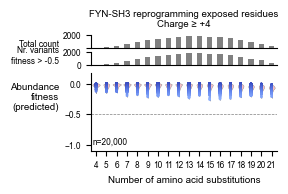

In [18]:
import seaborn as sns
import networkx as nx
from itertools import count
from seaborn import kdeplot
from itertools import groupby
import matplotlib
import numpy as np

vol_increase=50

filtered_phenotypes = charge_reprogram.loc[charge_reprogram['max_feature']=='poscharge']
filtered_phenotypes = filtered_phenotypes.sort_values('mean', ascending=False)

lowest_nham=int(filtered_phenotypes.sort_values('Nham_aa', ascending=True).iloc[0]['Nham_aa'])
highest_nham=int(filtered_phenotypes.sort_values('Nham_aa', ascending=False).iloc[0]['Nham_aa'])

total_core_viabilities = pd.DataFrame(columns=['protein', 'variants_above_01', 'variants_above_025', 'variants_above_05', 'variants_below_05'])
    

fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,0,12],'hspace': 0.15},figsize=(2.4,1.5))
plt.close()
fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,0,12],'hspace': 0.15},figsize=(2.4,1.5),sharex=ax1)


fig=sns.violinplot(x="Nham_aa", y="mean", data=filtered_phenotypes, inner=None, ax=ax2, color='lightpink', linewidth=0.3)
plt.axhline(y=-0.5, linestyle='--', color='gray', linewidth=0.5)

total_viable=0
nham_viability=pd.DataFrame(columns=['Number_of_variants','Fraction_50pc_folded'])
nham_viability["protein"] = pd.Series(dtype="object") 
nham_viability["nham"] = pd.Series(dtype=int) 
for nham in range(lowest_nham,highest_nham+1,1):
    if len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham]) > 0:
        nham_viability.at[nham,'protein']='FYN'
        nham_viability.at[nham,'nham']=nham
        nham_viability.at[nham,'Number_of_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])
        nham_viability.at[nham,'Fraction_50pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_50pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)
        nham_viability.at[nham,'Fraction_75pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.25].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_75pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.25].index)
        nham_viability.at[nham,'Fraction_90pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.1].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_90pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.1].index)
        total_viable=total_viable+len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)
for index, row in nham_viability.iterrows():
    nham_viability.at[index,'Fraction_of_total_50pc_viable_variants']= round(100*row['Number_of_50pc_folded_variants']/total_viable,1)

total_core_viabilities.at['core','variants_above_01']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.1].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_above_025']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.25].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_below_05']=5**7-len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_above_05']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.index)*5**7
    
   

sns.scatterplot(x=filtered_phenotypes['Nham_aa']-lowest_nham,y=filtered_phenotypes['mean'], hue=filtered_phenotypes['mean'],palette='coolwarm_r', hue_norm=(-1, 0),legend=False, s=3, edgecolor=None,ax=ax2,rasterized=True)
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.set_xlabel('Number of amino acid substitutions', fontsize=7)
ax2.set_ylabel("Abundance\nfitness\n(predicted)", fontsize=7,rotation='horizontal', ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=6)

nham_viability['Fraction_50pc_folded'] = pd.to_numeric(nham_viability['Fraction_50pc_folded'], errors='coerce')

ax1.spines[['top','right','left','bottom']].set_visible(False)
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False,top=False, right=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
ax2.annotate('n='+f"{len(filtered_phenotypes):,}", (-0.3,-1), fontsize=6)
plt.subplots_adjust(hspace=0.05)

nham_viability['Number_of_variants'].plot.bar(ax=ax0,fontsize=6,color='gray')
ax0.spines[['top','right']].set_visible(False)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax0.set_ylabel('Total count',fontsize=6, rotation='horizontal', ha='right')
ticks = ax0.get_yticks()
new_ticks = ticks[:-1]
ax0.set_yticks(new_ticks)
ticks = ax0.get_yticks()
labels = [label.get_text() for label in ax0.get_yticklabels()]
labels[0]= ""
ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)

nham_viability['Number_of_50pc_folded_variants'].plot.bar(ax=axviable,fontsize=6,color='gray')
axviable.spines[['top','right']].set_visible(False)
axviable.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axviable.set_ylabel('Nr. variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')

labeloffset= -0.17
ax0.get_yaxis().set_label_coords(labeloffset,0)
axviable.get_yaxis().set_label_coords(labeloffset,0)
ax1.get_yaxis().set_label_coords(labeloffset,-1)
ax2.get_yaxis().set_label_coords(labeloffset,0.5)
plt.ylim(-1.1,0.18)
ax0.set_title('FYN-SH3 reprogramming exposed residues\nCharge ≥ +4',fontsize=7)
plt.show()

/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '-' is not in color_dict. Using black.
  warnings.warn(str(Error))


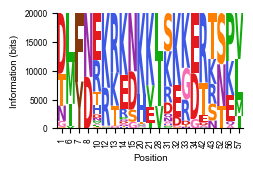

In [19]:
import logomaker as lm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

mut_pos_numbers = [0, 5, 6, 7, 9, 11, 12, 13, 14, 19, 20, 27, 30, 31, 32, 33, 41, 42, 51, 55, 56]

warnings.filterwarnings("ignore", category=FutureWarning, module="logomaker")

reprogram_MSA = pd.DataFrame(columns=np.arange(1,len(fyn_wt)+1,1))
for index, row in filtered_phenotypes.iterrows():
    reprogram_MSA.loc[index]=list(row.aa_seq)

aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
fig, ax = plt.subplots(figsize=(2.4, 1.5))

logo_df = pd.DataFrame(columns=aas)
logo_df = logo_df.astype(float)

for pos in range(1, len(reprogram_MSA.columns) + 1):
    df = reprogram_MSA[pos].value_counts().rename_axis('aa').reset_index(name='counts')
    for index, row2 in df.iterrows():
        logo_df.at[pos, row2.aa] = int(row2.counts)

logo_df = logo_df.fillna(0)

logo_df_subset = logo_df.loc[[i+1 for i in mut_pos_numbers]]

logo_df_subset_reset = logo_df_subset.reset_index()

prob_mat = lm.transform_matrix(logo_df_subset_reset.drop(columns='index'), from_type='counts', to_type='counts')
logo = lm.Logo(prob_mat, font_name='DejaVu Sans', ax=ax, color_scheme='dmslogo_funcgroup')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(range(len(mut_pos_numbers)))
ax.set_xticklabels([i+1 for i in mut_pos_numbers], fontsize=6,rotation=90)
ax.tick_params(axis='y', labelsize=6)

plt.xlabel('Position', fontsize=7)
plt.ylabel('Information (bits)', fontsize=7)

plt.show()


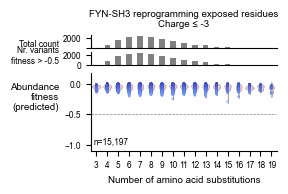

In [20]:
import seaborn as sns
import networkx as nx
from itertools import count
from seaborn import kdeplot
from itertools import groupby
import matplotlib
import numpy as np

vol_increase=50

filtered_phenotypes = charge_reprogram.loc[charge_reprogram['max_feature']=='negcharge']
filtered_phenotypes = filtered_phenotypes.sort_values('mean', ascending=False)

lowest_nham=int(filtered_phenotypes.sort_values('Nham_aa', ascending=True).iloc[0]['Nham_aa'])
highest_nham=int(filtered_phenotypes.sort_values('Nham_aa', ascending=False).iloc[0]['Nham_aa'])

total_core_viabilities = pd.DataFrame(columns=['protein', 'variants_above_01', 'variants_above_025', 'variants_above_05', 'variants_below_05'])
    

fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,0,12],'hspace': 0.15},figsize=(2.4,1.5))
plt.close()
fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,0,12],'hspace': 0.15},figsize=(2.4,1.5),sharex=ax1)


fig=sns.violinplot(x="Nham_aa", y="mean", data=filtered_phenotypes, inner=None, ax=ax2, color='lightpink', linewidth=0.3)
plt.axhline(y=-0.5, linestyle='--', color='gray', linewidth=0.5)

total_viable=0
nham_viability=pd.DataFrame(columns=['Number_of_variants','Fraction_50pc_folded'])
nham_viability["protein"] = pd.Series(dtype="object") 
nham_viability["nham"] = pd.Series(dtype=int) 
for nham in range(lowest_nham,highest_nham+1,1):
    if len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham]) > 0:
        nham_viability.at[nham,'protein']='FYN'
        nham_viability.at[nham,'nham']=nham
        nham_viability.at[nham,'Number_of_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])
        nham_viability.at[nham,'Fraction_50pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_50pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)
        nham_viability.at[nham,'Fraction_75pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.25].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_75pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.25].index)
        nham_viability.at[nham,'Fraction_90pc_folded']=round(100*(len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.1].index)/len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham])),1)
        nham_viability.at[nham,'Number_of_90pc_folded_variants']=len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.1].index)
        total_viable=total_viable+len(filtered_phenotypes.loc[filtered_phenotypes['Nham_aa']==nham].loc[filtered_phenotypes['mean']>=-0.5].index)
for index, row in nham_viability.iterrows():
    nham_viability.at[index,'Fraction_of_total_50pc_viable_variants']= round(100*row['Number_of_50pc_folded_variants']/total_viable,1)

total_core_viabilities.at['core','variants_above_01']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.1].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_above_025']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.25].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_below_05']=5**7-len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.index)*5**7
total_core_viabilities.at['core','variants_above_05']=len(filtered_phenotypes.loc[filtered_phenotypes['mean']>=-0.5].index)/len(filtered_phenotypes.index)*5**7
    
   

sns.scatterplot(x=filtered_phenotypes['Nham_aa']-lowest_nham,y=filtered_phenotypes['mean'], hue=filtered_phenotypes['mean'],palette='coolwarm_r', hue_norm=(-1, 0),legend=False, s=3, edgecolor=None,ax=ax2,rasterized=True)
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.set_xlabel('Number of amino acid substitutions', fontsize=7)
ax2.set_ylabel("Abundance\nfitness\n(predicted)", fontsize=7,rotation='horizontal', ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=6)

nham_viability['Fraction_50pc_folded'] = pd.to_numeric(nham_viability['Fraction_50pc_folded'], errors='coerce')

ax1.spines[['top','right','left','bottom']].set_visible(False)
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False,top=False, right=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
ax2.annotate('n='+f"{len(filtered_phenotypes):,}", (-0.3,-1), fontsize=6)
plt.subplots_adjust(hspace=0.05)

nham_viability['Number_of_variants'].plot.bar(ax=ax0,fontsize=6,color='gray')
ax0.spines[['top','right']].set_visible(False)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax0.set_ylabel('Total count',fontsize=6, rotation='horizontal', ha='right')
ticks = ax0.get_yticks()
new_ticks = ticks[:-1]
ax0.set_yticks(new_ticks)
ticks = ax0.get_yticks()
labels = [label.get_text() for label in ax0.get_yticklabels()]
labels[0]= ""
ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)

nham_viability['Number_of_50pc_folded_variants'].plot.bar(ax=axviable,fontsize=6,color='gray')
axviable.spines[['top','right']].set_visible(False)
axviable.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axviable.set_ylabel('Nr. variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')

labeloffset= -0.17
ax0.get_yaxis().set_label_coords(labeloffset,0)
axviable.get_yaxis().set_label_coords(labeloffset,0)
ax1.get_yaxis().set_label_coords(labeloffset,-1)
ax2.get_yaxis().set_label_coords(labeloffset,0.5)
plt.ylim(-1.1,0.18)
ax0.set_title('FYN-SH3 reprogramming exposed residues\nCharge ≤ -3',fontsize=7)
plt.show()

/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '-' is not in color_dict. Using black.
  warnings.warn(str(Error))


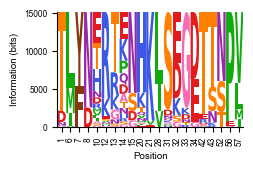

In [21]:
import logomaker as lm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

mut_pos_numbers = [0, 5, 6, 7, 9, 11, 12, 13, 14, 19, 20, 27, 30, 31, 32, 33, 41, 42, 51, 55, 56]

warnings.filterwarnings("ignore", category=FutureWarning, module="logomaker")

reprogram_MSA = pd.DataFrame(columns=np.arange(1,len(fyn_wt)+1,1))
for index, row in filtered_phenotypes.iterrows():
    reprogram_MSA.loc[index]=list(row.aa_seq)

aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
fig, ax = plt.subplots(figsize=(2.4, 1.5))

logo_df = pd.DataFrame(columns=aas)
logo_df = logo_df.astype(float)

for pos in range(1, len(reprogram_MSA.columns) + 1):
    df = reprogram_MSA[pos].value_counts().rename_axis('aa').reset_index(name='counts')
    for index, row2 in df.iterrows():
        logo_df.at[pos, row2.aa] = int(row2.counts)

logo_df = logo_df.fillna(0)

logo_df_subset = logo_df.loc[[i+1 for i in mut_pos_numbers]]

logo_df_subset_reset = logo_df_subset.reset_index()

prob_mat = lm.transform_matrix(logo_df_subset_reset.drop(columns='index'), from_type='counts', to_type='counts')
logo = lm.Logo(prob_mat, font_name='DejaVu Sans', ax=ax, color_scheme='dmslogo_funcgroup')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(range(len(mut_pos_numbers)))
ax.set_xticklabels([i+1 for i in mut_pos_numbers], fontsize=6,rotation=90)
ax.tick_params(axis='y', labelsize=6)

plt.xlabel('Position', fontsize=7)
plt.ylabel('Information (bits)', fontsize=7)

plt.show()
